## 1. INSTALACIÓN DE LIBRERÍAS

In [1]:
!pip install datasets xgboost -q

import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 2. CARGA DE DATOS REALES (BASE C/C++) - Sample

In [2]:
print("⬇️ Cargando base de datos real (C/C++)...")
ds = load_dataset("code_x_glue_cc_defect_detection")

# Tomamos una muestra para no saturar la RAM (10,000 muestras)
df_real = pd.DataFrame(ds['train']).sample(10000, random_state=42)
df_real = df_real[['func', 'target']]
df_real.columns = ['code', 'label'] # 0: Seguro, 1: Vulnerable

⬇️ Cargando base de datos real (C/C++)...


## 3. INYECCIÓN DE DATOS MULTI-LENGUAJE - Sample y Modificación

Aquí enseñamos al modelo patrones específicos de otros lenguajes que no están en el dataset de C/C++.

In [3]:
# 1. Cargar el CSV completo
# on_bad_lines='skip' ayuda si hay filas con más comas de las debidas
df_multi = pd.read_csv("CVEFixes.csv", on_bad_lines='skip') 

# 2. Filtrar solo las columnas necesarias
df_multi = df_multi[["code", "label"]]

# ==============================================================================
# 🔴 PASO CRÍTICO DE LIMPIEZA (Agrega esto)
# ==============================================================================
# Eliminar filas donde 'code' sea NaN (nulo)
print(f"Filas antes de limpiar: {len(df_multi)}")
df_multi = df_multi.dropna(subset=['code'])

# Asegurar que todo en la columna 'code' sea string (a veces Pandas lee números como float)
df_multi['code'] = df_multi['code'].astype(str)

# Opcional: Eliminar filas que sean strings vacíos o solo espacios
df_multi = df_multi[df_multi['code'].str.strip() != ""]
print(f"Filas después de limpiar nulos y vacíos: {len(df_multi)}")
# ==============================================================================

multi_lang_data = [
    # ==============================================================================
    # 🐍 PYTHON (Ampliando a Web Frameworks, Cripto y Path Traversal)
    # ==============================================================================
    # --- Vulnerable ---
    {"code": "import os; os.system('rm -rf /')", "label": 1},
    {"code": "eval(user_input)", "label": 1},
    {"code": "subprocess.call(cmd, shell=True)", "label": 1},
    {"code": "pickle.loads(payload)", "label": 1}, 
    {"code": "cursor.execute(f'SELECT * FROM users WHERE name={name}')", "label": 1},
    {"code": "yaml.load(data)", "label": 1},
    {"code": "open(request.args.get('filename'), 'r')", "label": 1}, # Path Traversal
    {"code": "hashlib.md5(password.encode()).hexdigest()", "label": 1}, # Weak Hash
    {"code": "render_template_string(user_input)", "label": 1}, # SSTI (Flask)
    {"code": "tarfile.open(fileobj=f, mode='r|*')", "label": 1}, # Zip Slip/Tar Bomb
    {"code": "tempfile.mktemp()", "label": 1}, # Deprecated/Race condition
    {"code": "requests.get(url, verify=False)", "label": 1}, # No SSL verification
    {"code": "exec(code_from_user)", "label": 1},
    {"code": "django.db.connection.cursor().execute('SELECT * FROM t WHERE id = %s' % id)", "label": 1},

    # --- Seguro ---
    {"code": "subprocess.call(['ls', '-l'])", "label": 0},
    {"code": "cursor.execute('SELECT * FROM users WHERE name=%s', (name,))", "label": 0},
    {"code": "yaml.safe_load(data)", "label": 0},
    {"code": "import ast; ast.literal_eval(user_input)", "label": 0},
    {"code": "open(werkzeug.utils.secure_filename(filename), 'r')", "label": 0}, # Safe path
    {"code": "hashlib.sha256(password.encode()).hexdigest()", "label": 0}, # Strong Hash
    {"code": "render_template('index.html', user=user_input)", "label": 0}, # Auto-escaped
    {"code": "tempfile.mkstemp()", "label": 0}, # Safe temp file
    {"code": "requests.get(url, verify=True)", "label": 0},
    {"code": "Model.objects.raw('SELECT * FROM t WHERE id = %s', [id])", "label": 0}, # Django safe

    # ==============================================================================
    # ☕ JAVA (Ampliando a Cripto, XXE, Deserialización y Spring Boot)
    # ==============================================================================
    # --- Vulnerable ---
    {"code": "Runtime.getRuntime().exec(request.getParameter(\"cmd\"));", "label": 1},
    {"code": "String query = \"SELECT * FROM accounts WHERE id = \" + id;", "label": 1},
    {"code": "logger.info(\"User: \" + userInput);", "label": 1}, 
    {"code": "xmlReader.setFeature(\"http://xml.org/sax/features/external-general-entities\", true);", "label": 1},
    {"code": "Cipher c = Cipher.getInstance(\"DES\");", "label": 1}, # Weak Crypto
    {"code": "Random r = new Random(); int token = r.nextInt();", "label": 1}, # Weak PRNG
    {"code": "ObjectInputStream ois = new ObjectInputStream(is); Object o = ois.readObject();", "label": 1}, # Unsafe Deserialization
    {"code": "response.addHeader(\"Set-Cookie\", \"session=\" + sessionID);", "label": 1}, # No HttpOnly/Secure
    {"code": "File f = new File(baseDir, userInput);", "label": 1}, # Path Traversal
    {"code": "jdbcTemplate.execute(\"INSERT INTO t VALUES ('\" + val + \"')\");", "label": 1},

    # --- Seguro ---
    {"code": "PreparedStatement stmt = conn.prepareStatement(\"SELECT * FROM users WHERE id=?\");", "label": 0},
    {"code": "ProcessBuilder pb = new ProcessBuilder(\"ls\", \"-l\");", "label": 0},
    {"code": "encoder.encodeForHTML(userInput);", "label": 0},
    {"code": "Cipher c = Cipher.getInstance(\"AES/GCM/NoPadding\");", "label": 0},
    {"code": "SecureRandom r = new SecureRandom(); byte[] token = new byte[16]; r.nextBytes(token);", "label": 0},
    {"code": "Cookie c = new Cookie(\"session\", id); c.setHttpOnly(true); c.setSecure(true);", "label": 0},
    {"code": "Path p = Paths.get(base).resolve(input).normalize(); if(!p.startsWith(base)) throw new Exception();", "label": 0},
    {"code": "jdbcTemplate.update(\"INSERT INTO t VALUES (?)\", val);", "label": 0},

    # ==============================================================================
    # 🌐 JAVASCRIPT / NODE.JS (Ampliando a Proto Pollution, ReDoS, JWT)
    # ==============================================================================
    # --- Vulnerable ---
    {"code": "const result = eval(req.body.code);", "label": 1},
    {"code": "element.innerHTML = userInput;", "label": 1},
    {"code": "db.find({ $where: `this.id == ${id}` });", "label": 1},
    {"code": "require('child_process').exec(cmd);", "label": 1},
    {"code": "setTimeout(\"alert(\" + input + \")\", 1000);", "label": 1}, # Implied eval
    {"code": "var re = new RegExp(userInput);", "label": 1}, # ReDoS possibility
    {"code": "lodash.merge({}, JSON.parse(payload));", "label": 1}, # Prototype Pollution
    {"code": "jwt.verify(token, 'secret_hardcoded');", "label": 1}, # Hardcoded secret
    {"code": "res.write(userInput);", "label": 1}, # Reflected XSS possibility
    {"code": "const fs = require('fs'); fs.readFile(req.query.path, cb);", "label": 1},

    # --- Seguro ---
    {"code": "element.innerText = userInput;", "label": 0},
    {"code": "element.textContent = userInput;", "label": 0},
    {"code": "db.find({ id: req.params.id });", "label": 0},
    {"code": "require('child_process').execFile('ls');", "label": 0},
    {"code": "setTimeout(function() { alert(input); }, 1000);", "label": 0},
    {"code": "var re = new RegExp(escapeRegex(userInput));", "label": 0},
    {"code": "const map = new Map(); map.set(key, val);", "label": 0}, # Safe structure
    {"code": "jwt.verify(token, process.env.JWT_SECRET);", "label": 0},
    {"code": "res.send(DOMPurify.sanitize(userInput));", "label": 0},
    {"code": "if (isValidPath(path)) fs.readFile(path, cb);", "label": 0},

    # ==============================================================================
    # 🔷 C# / .NET (Ampliando a Entity Framework, Serialization)
    # ==============================================================================
    # --- Vulnerable ---
    {"code": "var cmd = new SqlCommand(\"SELECT * FROM Users WHERE Name='\" + name + \"'\", conn);", "label": 1},
    {"code": "Process.Start(\"cmd.exe\", \"/c \" + args);", "label": 1},
    {"code": "DirectoryEntry de = new DirectoryEntry(\"LDAP://\" + userInput);", "label": 1},
    {"code": "BinaryFormatter formatter = new BinaryFormatter(); formatter.Deserialize(stream);", "label": 1}, # Insecure Deserialization
    {"code": "Html.Raw(model.Comment);", "label": 1}, # MVC XSS
    {"code": "context.Database.ExecuteSqlCommand(\"UPDATE dbo.Posts SET Title = '\" + title + \"'\");", "label": 1}, # EF Core Injection
    {"code": "MD5 md5 = MD5.Create();", "label": 1},
    {"code": "Response.Write(Request.QueryString[\"input\"]);", "label": 1},

    # --- Seguro ---
    {"code": "SqlCommand cmd = new SqlCommand(\"SELECT * FROM Users WHERE Name=@name\", conn);", "label": 0},
    {"code": "cmd.Parameters.AddWithValue(\"@name\", name);", "label": 0},
    {"code": "JsonSerializer.Deserialize<Type>(jsonString);", "label": 0},
    {"code": "Html.Encode(model.Comment);", "label": 0},
    {"code": "context.Database.ExecuteSqlCommand(\"UPDATE dbo.Posts SET Title = @p0\", title);", "label": 0},
    {"code": "SHA256 sha = SHA256.Create();", "label": 0},
    {"code": "Response.Write(HttpUtility.HtmlEncode(Request.QueryString[\"input\"]));", "label": 0},
]

specific_js_vulns = [
    {"code": "var ejecucion = eval(input_string);", "label": 1},
    {"code": "eval('var result = ' + req.body.data);", "label": 1},
    {"code": "const res = eval(userInput);", "label": 1},
    {"code": "window.eval(location.search.substring(1));", "label": 1},
    {"code": "setInterval('update(' + userFreq + ')', 1000);", "label": 1}, # Implicit eval
    {"code": "setTimeout('doAction(' + param + ')', 500);", "label": 1},   # Implicit eval
    {"code": "new Function('a', 'b', 'return ' + userLogic)(x, y);", "label": 1},

    {"code": "var ejecucion = JSON.parse(input_string);", "label": 0},
    {"code": "const res = parseInt(userInput, 10);", "label": 0},
    {"code": "window.eval('console.log(\"static safety check\")');", "label": 0}, # Static string is safe-ish
    {"code": "setInterval(function() { update(userFreq); }, 1000);", "label": 0},
    {"code": "setTimeout(() => doAction(param), 500);", "label": 0},
    {"code": "const func = function(a, b) { return a + b; };", "label": 0},

    {"code": "document.write(\"<h1>Bienvenido: \" + input_string + \"</h1>\");", "label": 1},
    {"code": "document.writeln(location.href);", "label": 1},
    {"code": "document.write('<img src=' + userImage + '>');", "label": 1},
    {"code": "parent.document.write(msg);", "label": 1},

    {"code": "console.log(\"Bienvenido: \" + input_string);", "label": 0},
    {"code": "document.getElementById('msg').textContent = location.href;", "label": 0},
    {"code": "var img = document.createElement('img'); img.src = userImage;", "label": 0},
    {"code": "document.write('Static Footer Content');", "label": 0}, # Static is rarely vuln

    {"code": "var elemento = document.getElementById(\"perfil\"); elemento.innerHTML = input_string;", "label": 1},
    {"code": "div.innerHTML = `<p>${userData}</p>`;", "label": 1},
    {"code": "document.body.innerHTML += userInput;", "label": 1},
    {"code": "item.outerHTML = '<li>' + data + '</li>';", "label": 1},
    {"code": "$('#profile').html(username);", "label": 1}, # jQuery Vulnerable

    {"code": "var elemento = document.getElementById(\"perfil\"); elemento.innerText = input_string;", "label": 0},
    {"code": "div.textContent = userData;", "label": 0},
    {"code": "document.body.innerText += userInput;", "label": 0},
    {"code": "div.innerHTML = DOMPurify.sanitize(input_string);", "label": 0}, # Sanitized
    {"code": "$('#profile').text(username);", "label": 0}, # jQuery Safe

    {"code": "if (input_string == 0) { console.log(\"Error\"); }", "label": 1},
    {"code": "if (req.body.id == 'admin') return true;", "label": 1},
    {"code": "if (user.role != 'guest') grantAccess();", "label": 1}, # != is also weak
    {"code": "return (hash == expectedHash);", "label": 1},
    {"code": "if (input == null)", "label": 1}, # Often vulnerable logic

    {"code": "if (input_string === 0) { console.log(\"Error\"); }", "label": 0},
    {"code": "if (req.body.id === 'admin') return true;", "label": 0},
    {"code": "if (user.role !== 'guest') grantAccess();", "label": 0},
    {"code": "return (hash === expectedHash);", "label": 0},
    {"code": "Object.is(input, null)", "label": 0},

    {"code": "var token = Math.random();", "label": 1},
    {"code": "const id = Math.floor(Math.random() * 1000);", "label": 1},
    {"code": "let sessionID = Date.now() + Math.random();", "label": 1},
    {"code": "function getToken() { return Math.random().toString(36); }", "label": 1},

    {"code": "var token = window.crypto.getRandomValues(new Uint32Array(1))[0];", "label": 0},
    {"code": "const id = crypto.randomBytes(16).toString('hex');", "label": 0},
    {"code": "let sessionID = uuid.v4();", "label": 0},
    {"code": "const array = new Uint8Array(10); crypto.getRandomValues(array);", "label": 0},
]

# Ampliamos artificialmente los datos sintéticos para darles peso en el entrenamiento
# (Los repetimos para que el modelo no los ignore frente a los 10k de C++)
multi_lang_data = multi_lang_data + specific_js_vulns
df_multi_own = pd.DataFrame(multi_lang_data * 750)

# Aseguramos que df_multi (el del CSV) no tenga nulos antes de concatenar
df_multi = df_multi.dropna(subset=['code'])

# Concatenamos todo
df = pd.concat([df_real, df_multi, df_multi_own]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Dataset Híbrido Final. Total muestras: {len(df)}")
conteo = df['label'].value_counts()
print(f"Distribución: {conteo.to_dict()} (0=Seguro, 1=Vuln)")

# Calculamos el peso para balancear clases (Vital para XGBoost)
# Si hay mucho código seguro, esto le da más importancia a encontrar vulnerabilidades.
scale_pos_weight = conteo[0] / conteo[1]

Filas antes de limpiar: 31194
Filas después de limpiar nulos y vacíos: 31159
✅ Dataset Híbrido Final. Total muestras: 135659
Distribución: {1: 70400, 0: 65259} (0=Seguro, 1=Vuln)


## 4. Exploración - Explore

In [17]:
!pip install matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


📊 INICIANDO ANÁLISIS EXPLORATORIO DE DATOS (EDA)...

--- 1. Balance de Clases ---
label
1    70400
0    65259
Name: count, dtype: int64
Porcentaje de Vulnerables: 51.89%

--- 2. Estadísticas por Tipo de Código (Promedios) ---
                   char_len         loc  complexity_proxy
Seguro (0)      9731.969797  527.446896         45.766132
Vulnerable (1)  8734.874943  472.705440         41.276193


/tmp/ipykernel_711579/2617656976.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#2ecc71', '#e74c3c'])


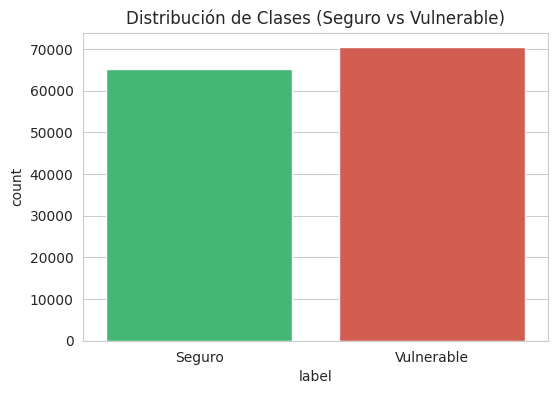

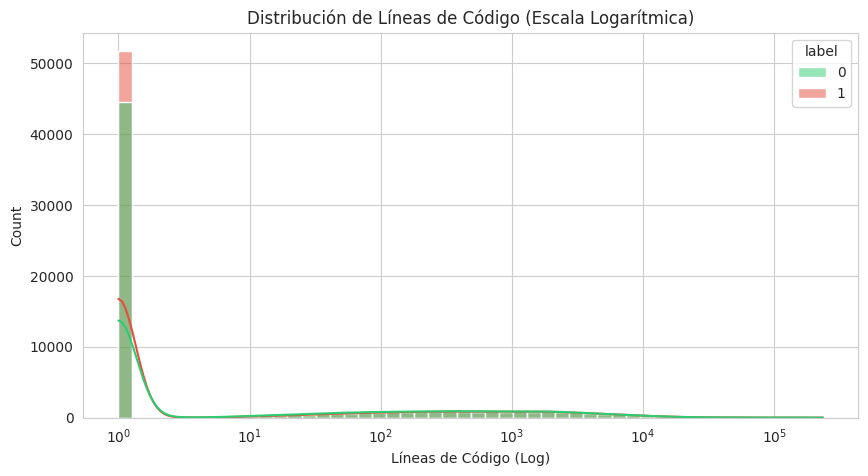

/tmp/ipykernel_711579/2617656976.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='complexity_proxy', data=df, palette=['#2ecc71', '#e74c3c'], showfliers=False)


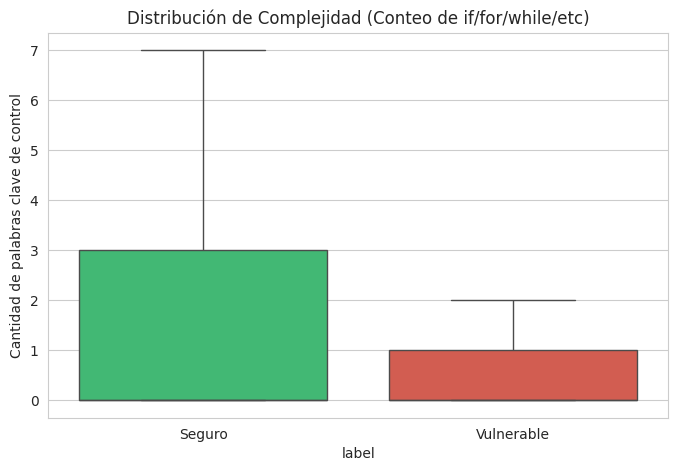

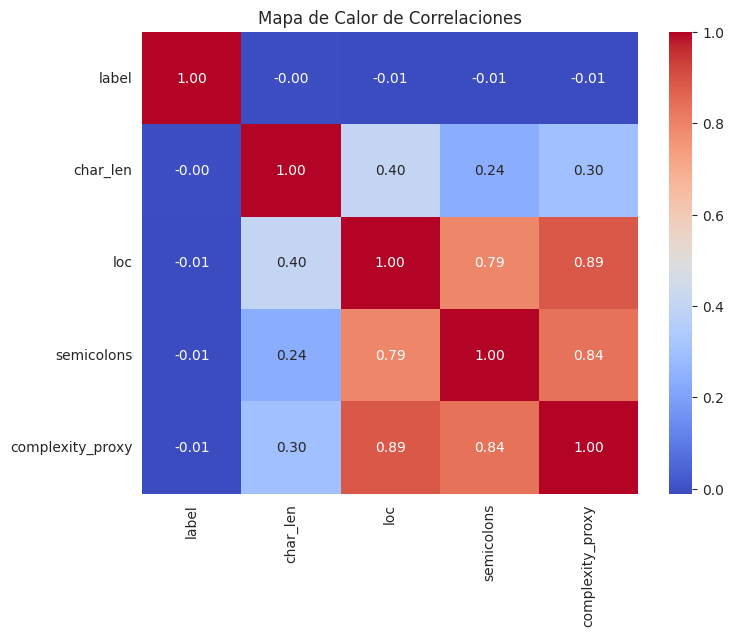


--- Top 10 Tokens en Código VULNERABLE ---
return: 599201
int: 395332
struct: 358407
null: 304897
case: 210500
void: 196296
data: 193266
static: 192177
image: 185908
const: 176013

--- Top 10 Tokens en Código SEGURO ---
return: 618944
int: 403058
struct: 368072
null: 311373
case: 217146
void: 202059
static: 200001
data: 198391
image: 188058
const: 182007


/tmp/ipykernel_711579/2617656976.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y_vuln), y=list(x_vuln), ax=axes[0], palette="Reds_r")
/tmp/ipykernel_711579/2617656976.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(y_safe), y=list(x_safe), ax=axes[1], palette="Greens_r")


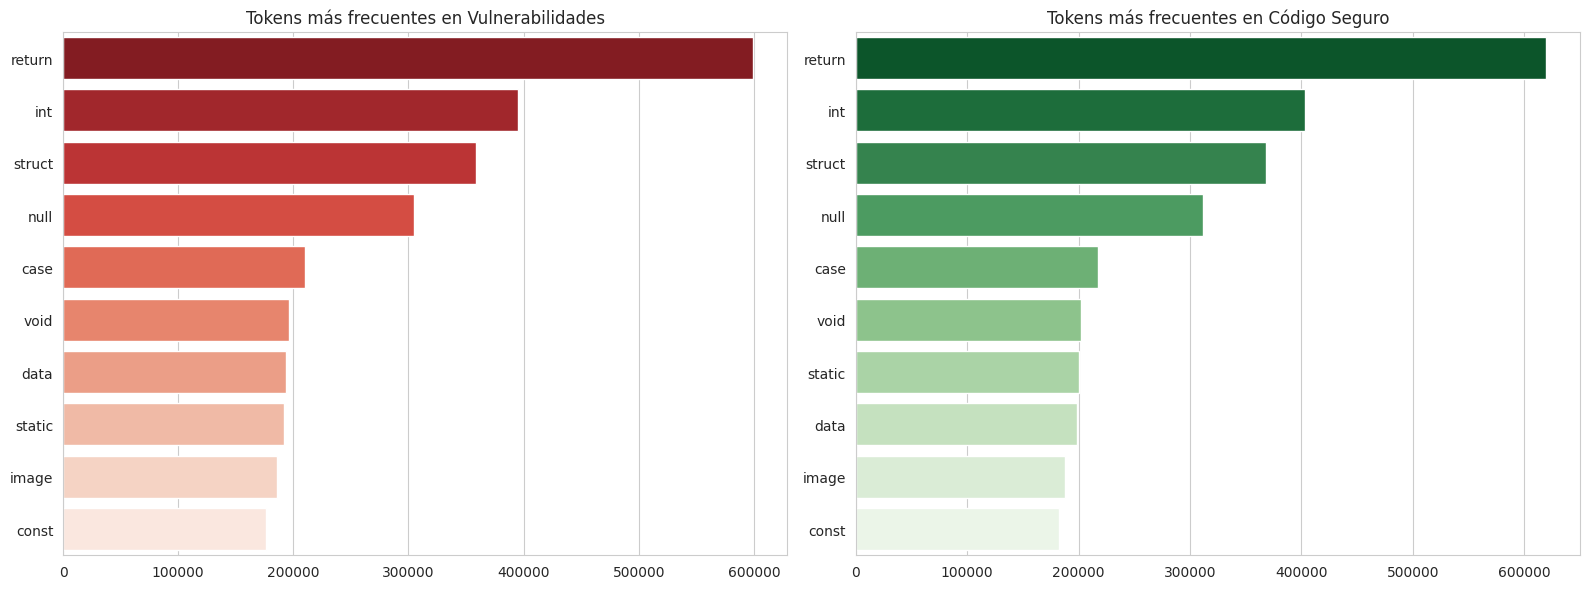

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("📊 INICIANDO ANÁLISIS EXPLORATORIO DE DATOS (EDA)...")

# ==============================================================================
# 1. INGENIERÍA DE CARACTERÍSTICAS (Crear métricas desde el texto)
# ==============================================================================
# Como solo tenemos texto, calculamos métricas proxy de complejidad
df['char_len'] = df['code'].str.len()                 # Longitud en caracteres
df['loc'] = df['code'].str.count('\n') + 1            # Líneas de código (Lineas of Code)
df['semicolons'] = df['code'].str.count(';')          # Cantidad de instrucciones (aprox para C/Java/JS)
df['complexity_proxy'] = df['code'].str.count(r'(if|for|while|switch|catch|else)') # Proxy de complejidad ciclomática

# ==============================================================================
# 2. ESTADÍSTICAS DESCRIPTIVAS GENERALES
# ==============================================================================
print("\n--- 1. Balance de Clases ---")
conteo = df['label'].value_counts()
print(conteo)
percentage_vuln = (conteo[1] / len(df)) * 100
print(f"Porcentaje de Vulnerables: {percentage_vuln:.2f}%")

print("\n--- 2. Estadísticas por Tipo de Código (Promedios) ---")
stats = df.groupby('label')[['char_len', 'loc', 'complexity_proxy']].mean()
stats.index = ['Seguro (0)', 'Vulnerable (1)']
print(stats)

# ==============================================================================
# 3. VISUALIZACIÓN DE DISTRIBUCIONES
# ==============================================================================

# Gráfico A: Distribución de Clases
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribución de Clases (Seguro vs Vulnerable)')
plt.xticks([0, 1], ['Seguro', 'Vulnerable'])
plt.show()

# Gráfico B: Histograma de Líneas de Código (LOC) - Logarítmico para ver mejor
# Usamos logaritmo porque a veces hay archivos enormes que rompen la escala
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='loc', hue='label', bins=50, kde=True, palette=['#2ecc71', '#e74c3c'], log_scale=True)
plt.title('Distribución de Líneas de Código (Escala Logarítmica)')
plt.xlabel('Líneas de Código (Log)')
plt.show()

# Gráfico C: Boxplot de Complejidad (Keywords de control de flujo)
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='complexity_proxy', data=df, palette=['#2ecc71', '#e74c3c'], showfliers=False)
plt.title('Distribución de Complejidad (Conteo de if/for/while/etc)')
plt.xticks([0, 1], ['Seguro', 'Vulnerable'])
plt.ylabel('Cantidad de palabras clave de control')
plt.show()

# ==============================================================================
# 4. MATRIZ DE CORRELACIÓN
# ==============================================================================
# ¿Existe relación entre ser largo y ser vulnerable?
plt.figure(figsize=(8, 6))
corr_matrix = df[['label', 'char_len', 'loc', 'semicolons', 'complexity_proxy']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlaciones')
plt.show()

# ==============================================================================
# 5. ANÁLISIS DE FRECUENCIA DE PALABRAS (MINERÍA DE TEXTO)
# ==============================================================================
# ¿Qué palabras aparecen más en el código vulnerable vs el seguro?

def get_top_grams(corpus, n=1, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english', max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Separamos corpus
vuln_code = df[df['label'] == 1]['code']
safe_code = df[df['label'] == 0]['code']

print("\n--- Top 10 Tokens en Código VULNERABLE ---")
top_vuln = get_top_grams(vuln_code, n=1)
for word, freq in top_vuln:
    print(f"{word}: {freq}")

print("\n--- Top 10 Tokens en Código SEGURO ---")
top_safe = get_top_grams(safe_code, n=1)
for word, freq in top_safe:
    print(f"{word}: {freq}")

# Visualización de palabras clave
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vulnerable Barplot
x_vuln, y_vuln = zip(*top_vuln)
sns.barplot(x=list(y_vuln), y=list(x_vuln), ax=axes[0], palette="Reds_r")
axes[0].set_title("Tokens más frecuentes en Vulnerabilidades")

# Safe Barplot
x_safe, y_safe = zip(*top_safe)
sns.barplot(x=list(y_safe), y=list(x_safe), ax=axes[1], palette="Greens_r")
axes[1].set_title("Tokens más frecuentes en Código Seguro")

plt.tight_layout()
plt.show()

## 4. VECTORIZACIÓN INTELIGENTE (NLP)

Token_pattern ajustado para capturar sintaxis de múltiples lenguajes ($, ->, ., @, etc.). `ngram_range` es importante para el contexto.

In [4]:
print("\n⚙️ Vectorizando con detección de sintaxis extendida...")

# CAMBIOS:
# 1. Aumentamos max_features a 8000 (más vocabulario).
# 2. token_pattern mejorado: Captura [], ==, ===, !=, &&, ||, <, > (Clave para XSS y Lógica).
# 3. min_df=2: Ignora palabras que aparecen una sola vez (ruido/nombres de variables únicos).

vectorizer = TfidfVectorizer(
    analyzer='word',
    # Este Regex captura palabras O secuencias de símbolos comunes en programación
    token_pattern=r"(?u)\b\w+\b|[\(\)\{\}\[\];=,.<>!+\-*/&|]+", 
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2 
)

X = vectorizer.fit_transform(df['code'])
y = df['label']

# Usamos stratify=y para asegurar que train y test tengan la misma proporción de virus/seguro
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


⚙️ Vectorizando con detección de sintaxis extendida...


## 5. ENTRENAMIENTO (XGBoost) - Modelado

In [5]:
print("\n🔥 Entrenando XGBoost con parámetros optimizados...")

model = xgb.XGBClassifier(
    n_estimators=200,        # Aumentamos árboles para aprender más detalles
    max_depth=10,            # Más profundidad para entender contextos largos
    learning_rate=0.05,      # Aprendizaje más lento pero más preciso (evita errores bruscos)
    subsample=0.8,           # Usa el 80% de datos por árbol (evita overfitting)
    colsample_bytree=0.8,    # Usa el 80% de columnas por árbol
    scale_pos_weight=scale_pos_weight, # Balancea si hay desigualdad de clases
    eval_metric='logloss',
    n_jobs=-1                # Usa todos los núcleos del procesador
)

model.fit(X_train, y_train)


🔥 Entrenando XGBoost con parámetros optimizados...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 6. EVALUACIÓN

In [10]:
!pip install shap -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [19]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy Global Mejorado: {acc*100:.2f}%")

# Mostramos reporte detallado para ver si falla en detectar vulnerables (Recall)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Seguro', 'Vulnerable']))

import shap
import pandas as pd
from IPython.display import HTML, display

# ==========================================
# 1. CONFIGURACIÓN DE SHAP (EXPLICABILIDAD)
# ==========================================
print("⚙️ Configurando el explicador SHAP (esto puede tardar unos segundos)...")

# Inicializamos el explicador sobre el modelo XGBoost
# TreeExplainer es específico para árboles y muy rápido
explainer = shap.TreeExplainer(model)

# Obtenemos el vocabulario (palabras) del vectorizador para saber qué es cada feature
feature_names = vectorizer.get_feature_names_out()

# Lista para acumular los resultados del reporte
reporte_items = []

# ==========================================
# 2. FUNCIÓN DE ANÁLISIS MEJORADA
# ==========================================
def analizar_riesgo(codigo, lenguaje_label="Desconocido"):
    # 1. Predicción
    vec = vectorizer.transform([codigo])
    prob_vuln = model.predict_proba(vec)[0][1]
    es_vulnerable = prob_vuln > 0.5
    
    # 2. Explicabilidad con SHAP
    # Calculamos los valores SHAP para este snippet específico
    shap_values = explainer.shap_values(vec)
    
    # Como vec es una matriz dispersa, shap_values también lo será o tendrá muchos ceros.
    # Necesitamos encontrar qué palabras contribuyeron más al riesgo.
    
    # Obtenemos los índices de las palabras que existen en este código
    feature_index = vec.indices
    
    # Creamos una lista de tuplas: (palabra, impacto_shap)
    # Solo nos interesan las palabras que empujan hacia la clase 1 (Vulnerable) -> shap > 0
    contribuyentes = []
    if len(shap_values.shape) > 1: 
        # Si es multiclase o binario output raw, a veces devuelve lista. 
        # XGBoost binario suele devolver un solo array. Ajustamos por si acaso:
        sv = shap_values[0] 
    else:
        sv = shap_values[0] # Para un solo sample

    for idx in feature_index:
        impacto = sv[idx]
        palabra = feature_names[idx]
        # Si el impacto es positivo alto, es un factor de riesgo
        # Si es negativo, es un factor de seguridad
        contribuyentes.append((palabra, impacto))
    
    # Ordenamos por impacto absoluto (los más importantes primero)
    contribuyentes.sort(key=lambda x: x[1], reverse=True)
    
    # Filtramos los "Culparles" (Top 3 palabras que hicieron saltar la alarma)
    top_riesgos = [f"<span class='token-danger'>{w} ({v:.2f})</span>" for w, v in contribuyentes if v > 0][:5]
    top_seguros = [f"<span class='token-safe'>{w} ({v:.2f})</span>" for w, v in contribuyentes if v < 0][:3]
    
    razon = ", ".join(top_riesgos) if top_riesgos else "Patrón complejo / Estructura"
    factores_mitigantes = ", ".join(top_seguros) if top_seguros else "Ninguno evidente"

    # 3. Formateo para HTML
    estado_html = "<span class='badge-danger'>PELIGROSO 🔴</span>" if es_vulnerable else "<span class='badge-success'>SEGURO 🟢</span>"
    color_row = "#ffe6e6" if es_vulnerable else "#e6fffa" # Rojo claro vs Verde claro
    
    # Limpiamos el código para que se vea bien en HTML
    codigo_display = codigo.strip().replace("<", "&lt;").replace(">", "&gt;")

    item = f"""
    <tr style="background-color: {color_row}; border-bottom: 1px solid #ddd;">
        <td style="padding: 10px;"><strong>{lenguaje_label}</strong></td>
        <td style="padding: 10px;"><pre style="margin:0; font-size: 0.9em;">{codigo_display}</pre></td>
        <td style="padding: 10px; text-align: center;">{estado_html}<br><small>{prob_vuln*100:.1f}% Riesgo</small></td>
        <td style="padding: 10px;">
            <strong>Factores de Riesgo:</strong><br>{razon}<br>
            <hr style="margin: 5px 0; border: 0; border-top: 1px dashed #ccc;">
            <small>Factores de Seguridad: {factores_mitigantes}</small>
        </td>
    </tr>
    """
    reporte_items.append(item)
    
    # Feedback en consola también
    print(f"Analizado: {lenguaje_label} -> {prob_vuln*100:.1f}%")

# ==========================================
# 3. EJECUCIÓN DE PRUEBAS
# ==========================================
print("\n🔍 --- AUDITORÍA Y GENERACIÓN DE REPORTE ---")

analizar_riesgo("cursor.execute(f'SELECT * FROM t WHERE id={x}')", "Python")
analizar_riesgo("cursor.execute('SELECT * FROM t WHERE id=%s', (x,))", "Python")
analizar_riesgo("Runtime.getRuntime().exec(userInput);", "Java")
analizar_riesgo("document.getElementById('app').innerHTML = userInput;", "JavaScript")
analizar_riesgo("var cmd = new SqlCommand(\"SELECT * FROM T WHERE N='\" + n + \"'\", c);", "C#")
analizar_riesgo("char b[10]; strcpy(b, input);", "C++")
analizar_riesgo("var ejecucion = eval(input_string);", "JavaScript")
analizar_riesgo("document.write('<h1>Bienvenido: ' + input_string + '</h1>');", "JavaScript")
analizar_riesgo("var elemento = document.getElementById('perfil');elemento.innerHTML = input_string;", "JavaScript")
analizar_riesgo("if (input_string == 0) { console.log('El input es cero o falso'); } return ejecucion;", "JavaScript")
analizar_riesgo("var token = Math.random(); return token;", "JavaScript")

analizar_riesgo("""
def add(a, b):
    result = a + b
    print(f"The result is {result}")
    return result
""", "Python")

analizar_riesgo("""
import os
def run_command(user_input):
    # This is a classic command injection vulnerability
    os.system("echo " + user_input)
""", "Python")

analizar_riesgo("""
def get_user_by_username(username):
    db = sqlite3.connect(":memory:")
    cursor = db.cursor()
    
    # La línea vulnerable. Un atacante podría pasar: ' OR '1'='1
    query = "SELECT * FROM users WHERE username = '" + username + "'"
    
    try:
        cursor.execute(query)
        return cursor.fetchall()
    except Exception as e:
        return str(e)
""", "Python")

analizar_riesgo("""
def get_user_by_username_safe(username):
    db = sqlite3.connect(":memory:")
    cursor = db.cursor()
    
    # La forma correcta y segura de hacerlo.
    query = "SELECT * FROM users WHERE username = ?"
    
    try:
        # La tupla (username,) pasa los datos de forma segura.
        cursor.execute(query, (username,))
        return cursor.fetchall()
    except Exception as e:
        return str(e)
""", "Python")

analizar_riesgo("""
#include <iostream>
#include <cstring>
void process_input(char* input) {
    char buffer[16];     
    strcpy(buffer, input);
    std::cout << "Buffer content: " << buffer << std::endl;
}
""", "C++")

# ==========================================
# 4. GENERAR ARCHIVO HTML FINAL
# ==========================================
html_template = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Reporte de Auditoría IA - SHAP</title>
    <style>
        body {{ font-family: sans-serif; padding: 20px; color: #333; }}
        h1 {{ color: #2c3e50; }}
        table {{ width: 100%; border-collapse: collapse; box-shadow: 0 0 10px rgba(0,0,0,0.1); }}
        th {{ background-color: #34495e; color: white; padding: 12px; text-align: left; }}
        .badge-danger {{ background-color: #e74c3c; color: white; padding: 4px 8px; border-radius: 4px; font-weight: bold; }}
        .badge-success {{ background-color: #27ae60; color: white; padding: 4px 8px; border-radius: 4px; font-weight: bold; }}
        .token-danger {{ color: #c0392b; font-weight: bold; background: #fadbd8; padding: 0 4px; border-radius: 3px; }}
        .token-safe {{ color: #1e8449; font-weight: bold; background: #d5f5e3; padding: 0 4px; border-radius: 3px; }}
        pre {{ white-space: pre-wrap; word-wrap: break-word; }}
    </style>
</head>
<body>
    <h1>🛡️ Reporte de Vulnerabilidades (IA + SHAP)</h1>
    <p>Este reporte detalla por qué el modelo clasificó cada fragmento. Los valores entre paréntesis indican el <strong>impacto SHAP</strong> (cuanto más alto, más contribuyó a la clasificación).</p>
    <table>
        <thead>
            <tr>
                <th width="10%">Lenguaje</th>
                <th width="40%">Snippet de Código</th>
                <th width="15%">Estado</th>
                <th width="35%">Análisis de Tokens (IA Explicable)</th>
            </tr>
        </thead>
        <tbody>
            {"".join(reporte_items)}
        </tbody>
    </table>
</body>
</html>
"""

# Guardar en disco
output_file = "reporte_seguridad.html"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(html_template)

print(f"\n✅ REPORTE GENERADO EXITOSAMENTE: {output_file}")


🎯 Accuracy Global Mejorado: 85.35%
              precision    recall  f1-score   support

      Seguro       0.77      0.98      0.87     13052
  Vulnerable       0.98      0.73      0.84     14080

    accuracy                           0.85     27132
   macro avg       0.88      0.86      0.85     27132
weighted avg       0.88      0.85      0.85     27132

⚙️ Configurando el explicador SHAP (esto puede tardar unos segundos)...

🔍 --- AUDITORÍA Y GENERACIÓN DE REPORTE ---
Analizado: Python -> 89.1%
Analizado: Python -> 45.5%
Analizado: Java -> 98.0%
Analizado: JavaScript -> 10.7%
Analizado: C# -> 97.0%
Analizado: C++ -> 16.2%
Analizado: JavaScript -> 94.8%
Analizado: JavaScript -> 98.4%
Analizado: JavaScript -> 97.1%
Analizado: JavaScript -> 48.1%
Analizado: JavaScript -> 94.9%
Analizado: Python -> 44.1%
Analizado: Python -> 99.2%
Analizado: Python -> 58.5%
Analizado: Python -> 49.4%
Analizado: C++ -> 38.1%

✅ REPORTE GENERADO EXITOSAMENTE: reporte_seguridad.html


## Exportar modelo

In [13]:
import joblib
import os

print("📦 Empaquetando modelo para producción...")

# 1. Guardar el modelo entrenado
joblib.dump(model, 'modelo_xgb_seguridad.pkl')
print("✅ Modelo guardado: modelo_xgb_seguridad.pkl")

# 2. Guardar el vectorizador (CRÍTICO: sin esto el modelo es inútil)
joblib.dump(vectorizer, 'vectorizador_tfidf.pkl')
print("✅ Vectorizador guardado: vectorizador_tfidf.pkl")

# 3. Comprimir ambos en un ZIP para facilitar la descarga
os.system('zip -r kit_seguridad_ia.zip modelo_xgb_seguridad.pkl vectorizador_tfidf.pkl')
print("✅ Archivos comprimidos en: kit_seguridad_ia.zip")

📦 Empaquetando modelo para producción...
✅ Modelo guardado: modelo_xgb_seguridad.pkl
✅ Vectorizador guardado: vectorizador_tfidf.pkl
  adding: modelo_xgb_seguridad.pkl (deflated 61%)
  adding: vectorizador_tfidf.pkl (deflated 63%)
✅ Archivos comprimidos en: kit_seguridad_ia.zip
